# Drug Classificiation Using KNN and XGBoost Classifiers


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import multilabel_confusion_matrix, f1_score, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

### Data Visualization

In [2]:
df=pd.read_csv("D:\Online courses\Kaggle\drug200.csv")
#refer to this link to go to the dataset download page
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [3]:
#check for missing values dataframe
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

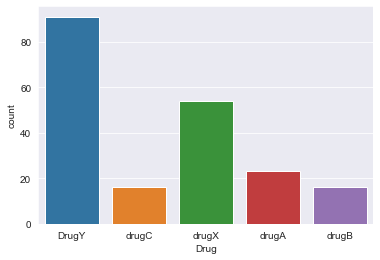

In [4]:
sns.set_style("darkgrid")
sns.countplot(x="Drug", data=df)

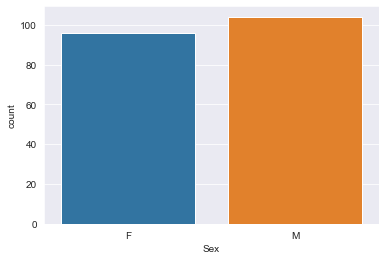

In [5]:
sns.countplot(x="Sex", data=df)

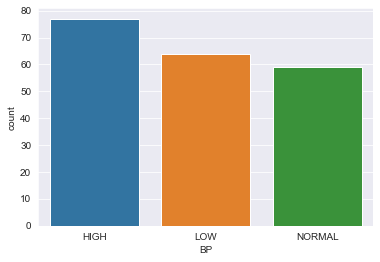

In [6]:
sns.countplot(data=df, x="BP")

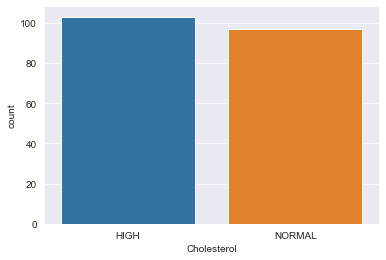

In [7]:
sns.countplot(data=df, x="Cholesterol")

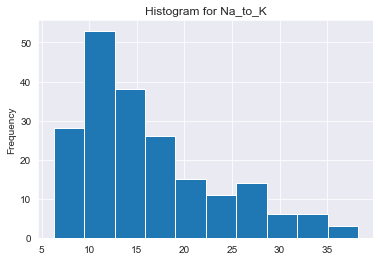

In [8]:
df["Na_to_K"].plot(kind="hist", title="Histogram for Na_to_K")

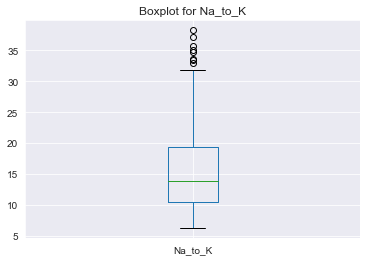

In [9]:
df["Na_to_K"].plot(kind="box", title="Boxplot for Na_to_K")

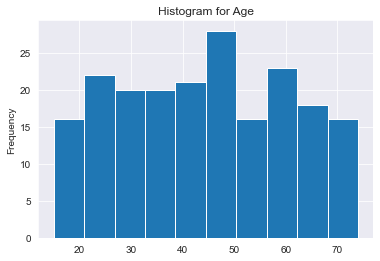

In [10]:
df["Age"].plot(kind="hist", title="Histogram for Age")

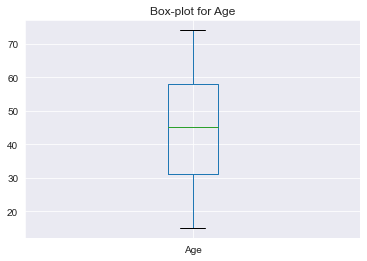

In [11]:
df["Age"].plot(kind="box", title="Box-plot for Age")

Within scikit-learn, all estimators supporting binary classification also support multiclass classification,
using One-vs-Rest by default.


### Pipeline setup

Separate pipeline for categorical and numerical features are made and combined later.
Categorical features are encoded with one-hot encoding. Numeric features will use StandardScaler to have mean of 0 and variance 1. 

In [12]:
X_1 = df.drop("Drug", axis=1)
y_1 = df["Drug"]

In [13]:
cat_pipeline = Pipeline(
    steps=[
        ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ]
)

num_pipeline = Pipeline(
    steps=[
        ("scale", StandardScaler())
    ]
)

Separate numeric and categorical columns, and pass them through their respective pipeline using ColumnTransformer

In [14]:
cat_cols = X_1.select_dtypes(exclude="number").columns
num_cols = X_1.select_dtypes(include="number").columns

In [15]:
col_trans = ColumnTransformer(transformers=[
    ("numeric", num_pipeline, num_cols),
    ("categorical", cat_pipeline, cat_cols)
])

In [16]:
X_p_1= col_trans.fit_transform(X_1)
y_p_1= y_1.values.reshape(-1,1)


Preprocess and split the data Classifier 

In [17]:
#Split the data into train and test sets
#X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42, stratify=y)
X_train_1, X_test_1,y_train_1, y_test_1 = train_test_split(X_p_1, y_p_1,test_size=0.2, stratify=y_p_1,random_state=42)


In [18]:
le =  LabelEncoder()
y_train_1 = le.fit_transform(y_train_1)
y_test_1 = le.fit_transform(y_test_1)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### KNN Classifier

In [19]:
knn_1 = KNeighborsClassifier()
knn_1.fit(X_train_1, y_train_1)
y_pred_1 = knn_1.predict(X_test_1)
print("Initial KNN accuracy is:", accuracy_score(y_test_1, y_pred_1))
f_knn_1 = f1_score(y_test_1, y_pred_1, average='micro')
print("Initial KNN F1 score is:", f_knn_1)

Initial KNN accuracy is: 0.675
Initial KNN F1 score is: 0.675


In [20]:
# inspecting the fit of the KNN model for different number of neighbours
neighbors = np.arange(1,13)
train_accuracies = {}
test_accuracies = {}
f_score = {}

for n in neighbors:

    #KNN model setup
    knn = KNeighborsClassifier(n_neighbors=n)

    # Fit the mode
    knn.fit(X_train_1, y_train_1)

    #compute accuracy
    train_accuracies[n] = knn.score(X_train_1, y_train_1)
    test_accuracies[n] = knn.score(X_test_1,y_test_1)
    y_pred = knn.predict(X_test_1)
    f_score[n] = f1_score(y_test_1, y_pred, average='micro')

In [21]:
def val_to_array(d):
    ''' takes dictionary d and returns a numpy array of its values'''
    v1 = d.values()
    v2 = list(v1)
    v3 = np.array(v2)
    
    return v3

In [22]:
# converting dict values to numpy array for plotting
train_acc_val = val_to_array(train_accuracies)
test_acc_val = val_to_array(test_accuracies)
f_scr_val = val_to_array(f_score)

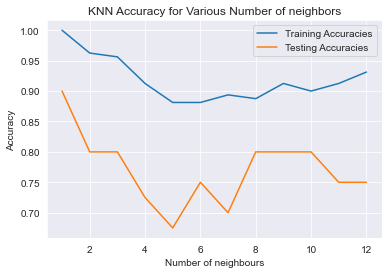

In [23]:
plt.title("KNN Accuracy for Various Number of neighbors")
plt.plot(neighbors, train_acc_val, label="Training Accuracies")
plt.plot(neighbors, test_acc_val, label="Testing Accuracies")
#plt.xlim([0,13])
#plt.ylim([0, 1])
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Number of neighbours")
plt.show()

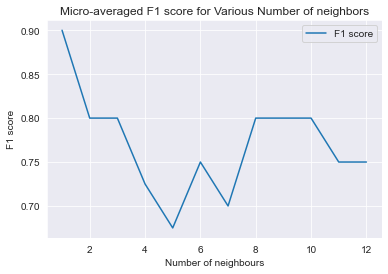

In [24]:
plt.title("Micro-averaged F1 score for Various Number of neighbors")
plt.plot(neighbors, f_scr_val, label="F1 score")
plt.legend()
plt.ylabel("F1 score")
plt.xlabel("Number of neighbours")
plt.show()

Hypertuning the KNN model

In [25]:
# tweek these hyperparameters for KNN model
param_grid_k = {
    "leaf_size": [1,5,10,20,50],
    "n_neighbors": [2,4,5,6,7],
    "p":[1,2,3],
    }

In [26]:
knn_2 = KNeighborsClassifier()
grid_cv_k = GridSearchCV(knn_2, param_grid_k, cv=5, n_jobs=-1)
knn_best = grid_cv_k.fit(X_train_1, y_train_1)

In [27]:
# parameters of best knn model
print(knn_best.best_params_)

{'leaf_size': 1, 'n_neighbors': 7, 'p': 3}


In [28]:
# setup KNN model using best params
knn_final = KNeighborsClassifier(n_neighbors=7,p=3, leaf_size=3) #seeing 4 neighbours give best results
knn_final.fit(X_train_1, y_train_1)
y_pred_1 = knn.predict(X_test_1)
print(f"KNN model prediction accuracy is: {knn_final.score(X_test_1, y_test_1)*100} %\n")
#print model predictions
#print("Predictions: {}\n".format(y_pred_1))
c_mat_k = multilabel_confusion_matrix(y_test_1, y_pred_1)
print("Confusion matrix for KNN Classier:\n")
print(c_mat_k)
print()
micro_avg_f1 = f1_score(y_test_1, y_pred_1, average='micro')
print(f"Micro-averaged F1 score is:{micro_avg_f1}")

KNN model prediction accuracy is: 75.0 %

Confusion matrix for KNN Classier:

[[[15  7]
  [ 3 15]]

 [[35  0]
  [ 3  2]]

 [[37  0]
  [ 1  2]]

 [[37  0]
  [ 2  1]]

 [[26  3]
  [ 1 10]]]

Micro-averaged F1 score is:0.75


In [29]:
c_mat_k.shape

(5, 2, 2)

### XGBoost Classifier

XGboost: Classifier setup, train and evaluation

In [30]:
#setup
xgb_1 = xgb.XGBClassifier()

#Fit the model
xgb_1.fit(X_train_1, y_train_1)

#Prediction
y_pred_xgb = xgb_1.predict(X_test_1)

#Accuracy
acc = accuracy_score(y_test_1, y_pred_xgb)
print(f"Accuracy score is: {acc*100} %")


Accuracy score is: 97.5 %


XGboost: Hypertuning the parameters


In [31]:
#tweeking these parameters of Xgboost classifier
param_grid_x = {
    "max_depth": [3,4,5],
    "learning_rate": [0.01, 0.03, 0.1],
    "gamma":[0, 0.25, 0.5],
    "reg_lambda":[0, 1, 5],
    }

In [32]:
#setup xbg classifier for gridsearchCV
xgb_2 = xgb.XGBClassifier()

#setup the gridcsearchCV
grid_cv_x = GridSearchCV(xgb_2, param_grid_x, cv=3, n_jobs=-1)

#
y_p_1 = le.fit_transform(y_p_1)
_ = grid_cv_x.fit(X_p_1, y_p_1)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [33]:
xgb_best_params = grid_cv_x.best_params_
xgb_best_params

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 5}

In [34]:
xgb_final = xgb.XGBClassifier(**xgb_best_params)
xgb_final.fit(X_train_1, y_train_1)
y_pred_xgb_final = xgb_final.predict(X_test_1)
acc_xgb_final = accuracy_score(y_test_1, y_pred_xgb_final)
f1_xgb_final = f1_score(y_test_1, y_pred_xgb_final, average='micro')
print(f"Accuracy of XGB Classifier after hypertuning is :{acc_xgb_final*100} %")
print(f"F1 score of XGB Classifier after hypertuning is :{f1_xgb_final*100} %")
print("Confusion matrix for XGBoost Classier:\n")
c_mat_x = multilabel_confusion_matrix(y_test_1, y_pred_xgb_final)
print(c_mat_x)

Accuracy of XGB Classifier after hypertuning is :95.0 %
F1 score of XGB Classifier after hypertuning is :95.0 %
Confusion matrix for XGBoost Classier:

[[[21  1]
  [ 0 18]]

 [[35  0]
  [ 1  4]]

 [[36  1]
  [ 0  3]]

 [[37  0]
  [ 0  3]]

 [[29  0]
  [ 1 10]]]
